In [1]:
!pip install numpy tqdm torch sentence-transformers transformers datasets matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=f585bf3adeda8eeebf3cca02bfdc5bde440e7b332b4808c75ef978e32bf4ccce
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [2]:
from torch.utils.data import Dataset
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util
import torch
import numpy as np
from typing import Literal
import tqdm.notebook as tqdm
import torch.nn.functional as F
import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

DatasetSplitType = Literal["train", "validation", "test"]

class EmbeddedQuestionAnsweringDatasetException(Exception):
    ...

class EmbeddedQuestionAnsweringDataset(Dataset):
    DATASET_NAME = "squad"
    EMBEDDING_MODEL_NAME = "sentence-transformers/all-distilroberta-v1"
    EMBEDDING_OUTPUT_DIM = 768
    EMBEDDING_MODEL_MAX_TOKENS = 512
    TOKENIZER_WORD_RATIO = 0.15 # average words / number of tokens rate
    SAMPLE_SIZE=12

    def __init__(self, dataset_split: DatasetSplitType = "train", as_tensors: bool = True, device: str | None = None) -> None:

        try:
            self._hf_dataset = load_dataset(self.DATASET_NAME)[dataset_split]
        except KeyError as e:
            raise EmbeddedQuestionAnsweringDatasetException(
                f"Dataset split: {dataset_split} not found! "
                f"Available splits: {load_dataset(self.DATASET_NAME).keys()}"
            ) from e

        self._model = SentenceTransformer(
            self.EMBEDDING_MODEL_NAME,
        ).to(device)
        self._max_seq_length = self._model.get_max_seq_length()
        self._model.max_seq_length = self._max_seq_length

        assert self.EMBEDDING_MODEL_MAX_TOKENS == self._max_seq_length
        self.shuffle = random.sample(range(len(self)), k=len(self))

        self._as_tensors = as_tensors
        self._device = device

        self._populate_dataset()

    def _populate_dataset(self):
        self._chunks = []

        for entry in tqdm.tqdm(self._hf_dataset):
            full_context, answer_start = (
                entry["context"],
                entry["answers"]["answer_start"][0],
            )

            self._chunks.append(
                self.get_relevant_chunk(
                    full_context,
                    answer_start,
                    self._max_seq_length * self.TOKENIZER_WORD_RATIO,
                )
            )

    def create_sample(self, idx):
        targets_to_populate = torch.zeros((self.SAMPLE_SIZE, 1))
        query_em_to_populate = torch.zeros((self.SAMPLE_SIZE, self.EMBEDDING_OUTPUT_DIM))

        question_embedding, result_embedding = self.__getitem__(idx)

        for i, sample_idx in enumerate(random.sample(range(len(self)), self.SAMPLE_SIZE)):
            _, sample_embedding = self.__getitem__(sample_idx)

            targets_to_populate[i] = F.cosine_similarity(
                result_embedding,
                sample_embedding,
            )
            query_em_to_populate[i] = sample_embedding

        question_embedding = question_embedding.repeat(self.SAMPLE_SIZE, 1)
        result_embedding = result_embedding.repeat(self.SAMPLE_SIZE, 1)

        assert (
            question_embedding.shape ==
            query_em_to_populate.shape ==
            result_embedding.shape
        )

        return (
            question_embedding,
            result_embedding,
            query_em_to_populate,
            targets_to_populate
        )


    def __len__(self) -> int:
        return self._hf_dataset.shape[0]

    def _encode(self, text: str):
        return self._model.encode(
            [text],
            convert_to_tensor=self._as_tensors,
            device=self._device,
            output_value=None
        )[0]

    def __getitem__(self, idx: int) -> tuple[np.ndarray, np.ndarray]:

        idx = self.shuffle[idx]
        padding = self._model.tokenizer.eos_token + self._model.tokenizer.pad_token * 512

        q_embeddings = self._encode(self._hf_dataset[idx]["question"] + padding)
        t_embeddings = self._encode(self._chunks[idx] + padding)

        return q_embeddings, t_embeddings


    def get_relevant_chunk(self, text: str, start: int, max_len: int) -> str:
        splitted = iter(text.split(". "))
        current = 0
        relevant_chunk = None
        words = 0

        for sent in splitted:
            current += len(sent)

            if current > start:
                break

        relevant_chunk = [sent]
        words = len(sent.split())

        for sent in splitted:
            if words > max_len:
                break

            words += len(sent.split())
            relevant_chunk.append(sent)

        return ". ".join(relevant_chunk)

train_dataset = EmbeddedQuestionAnsweringDataset(device=device)
test_dataset = EmbeddedQuestionAnsweringDataset(dataset_split="validation", device=device)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

  0%|          | 0/87599 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10570 [00:00<?, ?it/s]

In [3]:
from functools import partial
import torch
import torch.nn as nn
import torch.optim as optim


lr = 1.5e-05

class SkewModel(nn.Module):
    def __init__(self, input_size, max_tokens=512, zero_weights=False, hidden_size=10_000, batched=False):
        super(SkewModel, self).__init__()
        self.batched = batched

        self._encoder_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=64, dim_feedforward=3072, activation="relu", batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self._encoder_layer, num_layers=1)

        self.layer_norm = nn.LayerNorm(input_size)

        self.fc = nn.Linear(input_size, input_size)

        if zero_weights:
            for param in self.parameters():
                torch.nn.init.zeros_(param)

    def forward(self, token_embeddings, sentence_embeddings):
        transformer_encoder_out = self.transformer_encoder(token_embeddings)
        normalized = self.layer_norm(transformer_encoder_out.sum(1 if self.batched else 0))

        skewed = self.fc(normalized)

        return skewed + sentence_embeddings


In [4]:
model = SkewModel(input_size=768, zero_weights=False, batched=True).to(device)
model.load_state_dict(torch.load("/kaggle/input/skewmodel/skewModel.bin"))
model.eval()

SkewModel(
  (_encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
    (linear1): Linear(in_features=768, out_features=3072, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=3072, out_features=768, bias=True)
    (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (lin

In [13]:
%%capture
import torch.nn as nn
import torch.utils.data as data
import matplotlib.pyplot as plt


BATCH_SIZE = 28
temp_criterion = nn.CosineEmbeddingLoss()
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)
target = torch.ones(BATCH_SIZE).to(device)


def test():
    model.eval()
    losses = []
    baseline_losses = []

    with torch.no_grad():
        for inputs, targets in tqdm.tqdm(test_loader):
            outputs = model(inputs["token_embeddings"], inputs["sentence_embedding"])
            targets = targets["sentence_embedding"]

            if inputs["token_embeddings"].shape[0] != BATCH_SIZE:
                real_target = torch.ones(inputs["token_embeddings"].shape[0]).to(device)
            else:
                real_target = target

            loss = temp_criterion(outputs, targets, real_target)
            baseline_loss = temp_criterion(inputs["sentence_embedding"], targets, real_target)

            losses.append(loss.cpu().detach().numpy())
            baseline_losses.append(baseline_loss.cpu().detach().numpy())

    return losses, baseline_losses

losses, baseline = test()
plt.plot(losses)
plt.plot(baseline)
plt.ylim(0, 1)
plt.title("Loss for the test dataset")

Text(0.5, 1.0, 'Loss for the test dataset')

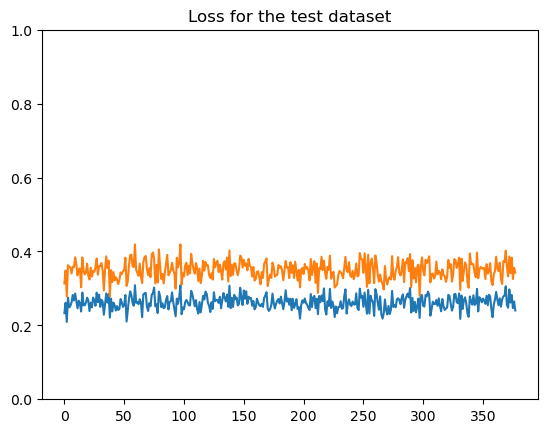

In [14]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.plot(baseline)
plt.ylim(0, 1)
plt.title("Loss for the test dataset")